<a href="https://colab.research.google.com/github/coldstalgia/SAAanalysis/blob/main/SAAanalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Run these codes first in order to install the necessary libraries and perform authorization.
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
%cd /content/drive/My Drive/TESI

In [ ]:
import openpyxl as opyxl
import datetime
from copy import copy

# apro tabella dati atmosferici 2014 - 2015 - 2016
weather_dates = {
    'data_2014': opyxl.load_workbook(filename='Firenze-2014-tutto.xlsx').active,
    'data_2015': opyxl.load_workbook(filename='Firenze-2015-tutto.xlsx').active,
    'data_2016': opyxl.load_workbook(filename='Firenze-2016-tutto.xlsx').active,
}

class WeatherManager:       # ============================ SEZIONE IMPOSTAZIONE DATI ATMOSFERICI ===============================================
    def __init__(self, work_sheet):
        self.sheet = work_sheet

    def get_variable(self, year, column_letter):
        weather_var = list(weather_dates['data_{}'.format(year)][column_letter])     # prendo variabile da colonna column_letter, file xlsx anno year
        del weather_var[0]       # elimino titolo colonna 
        weather_var = [elem.value for elem in weather_var]
        
        return weather_var
    

    def create_variable_column(self, title, old_column_letter, new_column_letter):  # label: string, new_column_letter: string
        new_sheet[f'{new_column_letter}1'].value = title  # setto titolo
        variable_list = self.get_variable(2014, old_column_letter)
        variable_list += self.get_variable(2015, old_column_letter)
        variable_list += self.get_variable(2016, old_column_letter)     # concatenazione di liste contenente dati pressioni dal 2014 al 2016

        col_index = opyxl.utils.cell.column_index_from_string(new_column_letter)
        for index, var in enumerate(variable_list):
            # value_displayed = 'NOT_FOUND' if ((var == None) or (var == 0)) else var     # Non ci sono dati per tutti i giorni dell'anno
            # self.sheet.cell(row=2+index, column=col_index, value=value_displayed)
            self.sheet.cell(row=2+index, column=col_index, value=var)




class Stylist:              # ========================== SEZIONE IMPOSTAZIONE STILI CELLE =================================================
    def __init__(self, old_sheet, new_sheet):
        self.old_sheet = old_sheet
        self.new_sheet = new_sheet
    
    def set_titles_style(self):
        title_date_font = copy(self.old_sheet['B1'].font)       # blue - data
        self.new_sheet['A1'].font = title_date_font
        final_dg_font = copy(self.old_sheet['C1'].font)   # red - dissezione aortica
        self.new_sheet['D1'].font = final_dg_font

        other_font = copy(self.old_sheet['D1'].font)      # green - altre malattie
        col_sublist = list(self.old_sheet['D1:N1'][0])   # primo elemento della tupla di tuple
        for index, cell in enumerate(col_sublist):
            self.new_sheet.cell(row=1, column=5+index).font = other_font

    def set_dates_style(self):
        date_font = copy(self.old_sheet['B2'].font)      # blue

        for index, cell in enumerate(self.new_sheet['A']):
            self.new_sheet.cell(row=2+index, column=1).font = date_font

    def set_cells_style(self):
        self.set_titles_style()
        self.set_dates_style()




class TableManager:              # ========================== SEZIONE CREA TABELLA =================================================       
    def __init__(self, old_sheet, new_sheet):
        self.old_sheet = old_sheet
        self.new_sheet = new_sheet

    def create_full_years(self):
        full_years = []

        start_date = datetime.date(2014, 1, 1)
        end_date = datetime.date(2016, 12, 31)
        delta = datetime.timedelta(days=1)

        while start_date <= end_date:
            full_years.append(start_date)
            start_date += delta

        return full_years


    def create_first_row(self):
        self.new_sheet['A1'].value = 'vdate'
        self.new_sheet['B1'].value = 'num_ospedalizzazioni'
        self.new_sheet['C1'].value = 'Uniq_ID'

        col_sublist = list(self.old_sheet['C1:N1'][0])   # primo elemento della tupla di tuple
        for index, cell in enumerate(col_sublist):
            self.new_sheet.cell(row=1, column=4+index, value=cell.value)


    def init_row(self, day, new_sheet_row_index):
        self.new_sheet['A{}'.format(new_sheet_row_index)].value = day # datetime.datetime.combine(day, datetime.datetime.min.time())   # vdate
        self.new_sheet['B{}'.format(new_sheet_row_index)].value = 0  # num_ospedalizzazioni
        self.new_sheet['C{}'.format(new_sheet_row_index)].value = '' # Uniq_ID

        col_sublist = list(self.new_sheet['D{row}:O{row}'.format(row=new_sheet_row_index)][0])   # scrivo 0 sulle colonne delle altre malattie
        for cell in col_sublist:
            cell.value = 0


    def copy_row(self, old_row, new_sheet_row_index):
        self.new_sheet['B{}'.format(new_sheet_row_index)].value += 1   # copio num_ospedalizzazioni

        id = self.new_sheet['C{}'.format(new_sheet_row_index)].value   # controllo se ho già inserito altri id => non è la prima ospedalizzazione
        self.new_sheet['C{}'.format(new_sheet_row_index)].value = old_row[0].value if (id == '') else id + ', ' + old_row[0].value   # aggiungo id paziente

        other_disease = old_row[2:]   # Prendo solo valori altre malattie. Tolgo primi due elementi riga da copiare => id e data
        other_disease = [elem.value for elem in other_disease]
        for index, disease in enumerate(other_disease):
            cell_value = self.new_sheet.cell(row=new_sheet_row_index, column=4+index).value
            self.new_sheet.cell(row=new_sheet_row_index, column=4+index, value=cell_value+disease)


    def remove_empty_cells(self, row_or_column):    # row_or_column = lista contenente valori di un insieme di celle 
        i = 1
        while(row_or_column[-i] == None):
            del row_or_column[-1]


    def create_new_table(self):
        self.create_first_row()

        full_years = self.create_full_years()
        last_day_of_the_years = full_years[-1]    # ultimo giorno del lasso di tempo studiato => utile per controlli
        full_years = iter(full_years)

        hospital_dates = list(self.old_sheet['B'])
        hospital_dates = [day.value for day in hospital_dates]    # trasformo tupla in una lista contenente i valori delle celle
        hospital_dates = hospital_dates[1:]   # rimuovo primo elemento colonna => 'vdate'
        self.remove_empty_cells(hospital_dates)    # rimuovo eventuali celle vuote dalla coda

        current_day = next(full_years)
        new_sheet_row_index = 2
        for self.old_sheet_row_index, hospital_day in enumerate(hospital_dates):    
            while(hospital_day.date() >= current_day):   # aggiunge giorni dell'anno, anche se non ci sono state ospedalizzazioni
                self.init_row(current_day, new_sheet_row_index)   # inizializzo riga self.new_sheet con valori: data, 0(per #ospedalizzazioni e malattie) e ''(per id pazienti)
                
                current_day = next(full_years)
                new_sheet_row_index += 1

            # arrivato qua, nel giorno dell'anno ho trovato una data di ospedalizzazione: hospital_day.date() == current_day
            new_sheet_row_index -= 1
            old_row = self.old_sheet['A{row}:N{row}'.format(row = self.old_sheet_row_index+2)][0]  # Prendo riga da copiare. indice+2 => i dati sono salvati dalla seconda riga in poi.
            self.copy_row(old_row, new_sheet_row_index)    # Copio riga su nuova tabella
        
            new_sheet_row_index += 1

            # Dopo aver scritto l'ultima ospedalizzazione, scrivo righe vuote fino all'ultimo giorno dei 3 anni
            if(self.old_sheet_row_index == len(hospital_dates)-1):     # controllo se siamo nell'ultima data di ospedalizzazione
                while(current_day < last_day_of_the_years):
                    self.init_row(current_day, new_sheet_row_index)   # inizializzo riga self.new_sheet con valori: data, 0(per #ospedalizzazioni e malattie) e ''(per id pazienti)
                    current_day = next(full_years)
                    new_sheet_row_index += 1

                self.init_row(current_day, new_sheet_row_index)    # Scrivo ultima riga, relativa all'ultimo giorno
  


# ======================================================================= °°° =======================================================================
# ======================================================================= °°° =======================================================================

# apro tabella ospedalizzazioni
old_hospital_file = opyxl.load_workbook(filename='Tabella_Santi_def_2.xlsx')
old_sheet = old_hospital_file.active

# creo nuova tabella
new_hospital_file = opyxl.Workbook() 
new_sheet = new_hospital_file.active

# creo tabella
table_manager = TableManager(old_sheet, new_sheet)
table_manager.create_new_table()

# aggiungo colori alle colonne
stylist = Stylist(old_sheet, new_sheet)
stylist.set_cells_style()

# aggiungo colonne dati atmosferici
weather_manager = WeatherManager(new_sheet)
weather_manager.create_variable_column('pressione_mb', 'L', 'Q')    # col_name, old_index, new_index
weather_manager.create_variable_column('mean_temp', 'C', 'R')
weather_manager.create_variable_column('min_temp', 'D', 'S')
weather_manager.create_variable_column('max_temp', 'E', 'T')
weather_manager.create_variable_column('humidity', 'G', 'U')
weather_manager.create_variable_column('mean_wind', 'I', 'V')
weather_manager.create_variable_column('max_wind', 'J', 'W')

# salvo nuova tabella
new_hospital_file.save(filename='final_table.xlsx')

In [ ]:
# ADD UNKNOWED DATA (aggiunte guardando da grafici LAMMA)
table_file = opyxl.load_workbook(filename='final_table.xlsx')
sheet = table_file.active

sheet['Q192'].value = 1004
sheet['Q291'].value = 1014
sheet['Q559'].value = 1012
sheet['Q576'].value = 1006
sheet['Q599'].value = 1016
sheet['Q824'].value = 1013
sheet['Q832'].value = 1007
sheet['Q1051'].value = 1025


sheet['R192'].value = 19
sheet['R559'].value = 28
sheet['R576'].value = 26
sheet['R599'].value = 23
sheet['R751'].value = 0
sheet['R824'].value = 18
sheet['R832'].value = 15

table_file.save(filename='final_table.xlsx')

In [ ]:
# ======================================================================================== 
# ======================================================================================== 
# ======================================================================================== 
# ======================================================================================== 
# ========================  SEZIONE ELABORAZIONE DATI ====================================  
# ======================================================================================== 
# ======================================================================================== 
# ======================================================================================== 
# ========================================================================================  

In [ ]:
# ============================ RUN FIRST ============================
import openpyxl as opyxl
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from statsmodels.graphics import tsaplots
import scipy.stats as stats
import math
from google.colab import files      # utile per salvataggio e download plots

# set up the DataFrame
pd.read_excel('final_table.xlsx').to_csv('final_table.csv')
table = pd.read_csv('final_table.csv')

table['vdate'] = pd.to_datetime(table['vdate'])     # trasformo in datetime la colonna relativa alle date


# Two things to be cautious when using Pearson correlation is that:
# 1) outliers can skew the results of the correlation estimation
# 2) it assumes the data are homoscedastic such that the variance of your data is homogenous across the data range

table.loc[394, 'pressione_mb'] = np.NaN
table.loc[395, 'pressione_mb'] = np.NaN


table = table[['vdate', 'num_ospedalizzazioni', 'FINAL_Dg', 'pressione_mb', 'mean_temp', 'min_temp', 'max_temp', 'humidity', 'mean_wind', 'max_wind']]       # filter table
table = table.rename(columns={'FINAL_Dg': 'final_dg'})      # rename colonna casi diss aortica

table['diff_temp'] = table['max_temp'] - table['min_temp']  # creo colonna differenza tra max e min temperatura giornaliera

# Ci sono dati mancanti relativi a parametri metereologici. Interpolo per risolvere il problema, utilizzando la colonna 0
table['pressione_mb'].replace(0, np.NaN, inplace=True)  # Nel file dati metereologi un paio di entrate avevano pressione = 0mbar: Impossibile!!
table.interpolate(method='linear', limit_direction='forward', axis=0, inplace=True) #method='spline', order=4
table = table.round(0)

In [ ]:
# PLOT OUTLIERS
index = table.loc[(table.pressione_mb < 1000) | (table.pressione_mb >1032)].pressione_mb.index
# table.drop(index, inplace=True)   # inplace = True modifica il df corrente, inplace = False ti restituisce un df
# table.reset_index(drop=True, inplace=True)   # reset index => starts with index = 0
table.loc[index, 'pressione_mb'] = 0
table['pressione_mb'].replace(0, np.NaN, inplace=True)  # Nel file dati metereologi un paio di entrate avevano pressione = 0mbar: Impossibile!!
table.interpolate(method='linear', limit_direction='forward', axis=0, inplace=True) #method='spline', order=4
table = table.round(0)

frame = {'pressure': table['pressione_mb']}
df = pd.DataFrame(frame)
df.boxplot()

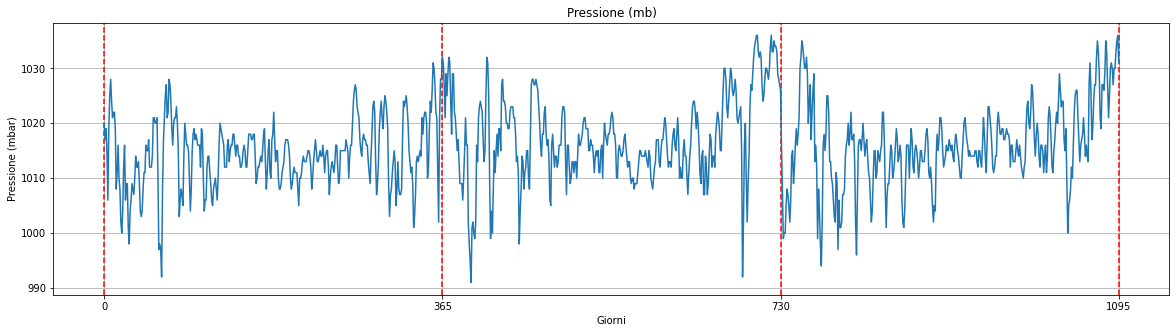

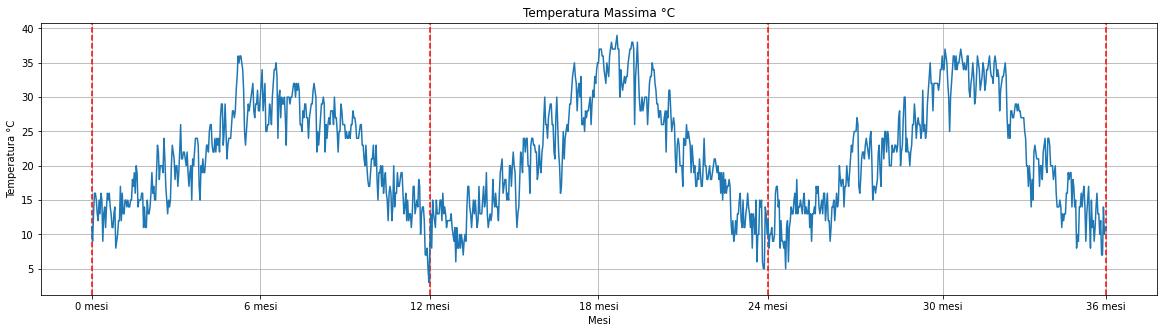

In [ ]:
# ========================  TIME SERIES SUB-PLOT ====================================

table.set_index('vdate')     # setto la data come indice di lavoro

# PRESSION time series
plt.figure(figsize=(20,5))
f = plt.figure(1)
plt.title('Pressione (mb)')

plt.xticks([0, 365, 365*2, 365*3])
for i in range(0, 4):
    plt.axvline(x=365*i, color='red', linestyle='dashed')

plt.xlabel('Giorni')
plt.ylabel('Pressione (mbar)')
table['pressione_mb'].plot(linewidth=1.5)
f.show()
plt.grid()
# # plt.savefig('pressure-time-series.png')
# files.download('pressure-time-series.png')


# MAX TEMPERATURE time series
plt.figure(figsize=(20,5))
g = plt.figure(2)
plt.title('Temperatura Massima °C')

mesi = [0, 182, 365, 547, 730, 919, 1095]
plt.xticks(mesi, labels=['0 mesi', '6 mesi', '12 mesi', '18 mesi', '24 mesi', '30 mesi', '36 mesi'])
for i in range(4):
    plt.axvline(x=365*i, color='red', linestyle='dashed')

plt.xlabel('Mesi')
plt.ylabel('Temperatura °C')
table['max_temp'].plot(linewidth=1.5)
g.show()
plt.grid()
# plt.savefig('max-temp-time-series.png')
# files.download('max-temp-time-series.png')


# NUM OSPEDALIZZAZIONI time series
# plt.figure(figsize=(20,5))
# h = plt.figure(3)
# plt.title('Numero Ospedalizzazioni')

# plt.xticks([0, 365, 365*2, 365*3])
# for i in range(0, 4):
#     plt.axvline(x=365*i, color='red', linestyle='dashed')

# plt.xlabel('Giorni')
# plt.ylabel('Num Ospedalizzazioni')
# table['num_ospedalizzazioni'].plot(linewidth=1.5)
# h.show()
# plt.grid()
# plt.savefig('ospedalizzazioni-time-series.png')
# files.download('ospedalizzazioni-time-series.png')


# MAX WIND time series
# plt.figure(figsize=(20,5))
# k = plt.figure(4)
# plt.title('Raffiche Vento Massime (km/h)')

# plt.xticks([0, 365, 365*2, 365*3])
# for i in range(0, 4):
#     plt.axvline(x=365*i, color='red', linestyle='dashed')

# plt.xlabel('Giorni')
# plt.ylabel('Vento km/h')
# table['max_wind'].plot(linewidth=1.5)
# k.show()
# plt.grid()
# plt.savefig('max-wind-time-series.png')
# files.download('max-wind-time-series.png')


# scatter plot
# data = table['num_ospedalizzazioni'].to_numpy()
# plt.scatter(range(1, len(data)+1), data)

In [ ]:
# ========================  DEASESONALITY/(DETREND) pressures time series ====================================

# METODO 1 - Media Mobile    
def rolling_mean(column, win_size):
    data = column.rolling(window=win_size).mean()    # Calcola media mobile su finestra di win_size
    data.drop(list(range(win_size-1)), inplace=True)   # indici da 0,..,win_size-2 == NaN
    data.reset_index(drop=True, inplace=True)   # reset index => starts with index = 0

    return data

# METODO 2 - Sottrazione valori adiacenti
def differencing(column):

    data = column.to_numpy()

    deseason_data = []
    for i in range(1, len(data)):
    	value = data[i] - data[i - 1]
    	deseason_data.append(value)
    
    deseason_column = pd.Series(deseason_data)
    return deseason_column

# df = table[['pressione_mb', 'num_ospedalizzazioni']]
# df['pressione_mb'] = df.pressione_mb.diff()
# print(df)

# METODO 3 - Seasonal differencing
def seasonal_differencing(column, season_win):

    data = column.to_numpy()

    deseason_data = []
    for t in range(season_win, len(column)):
        value = data[t] - data[t - season_win]
        deseason_data.append(value)

    deseason_column = pd.Series(deseason_data)
    return deseason_column

# METODO 3 - sqrt()
# METODO 4 - log()

# fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20,15))
# fig.suptitle('Pressione (mbar)', fontsize=15, y=0.92)

# ax1.set_title('Log')
# ax1.set_ylabel('mbar')
# ax1.grid()
# ax1.plot(np.log(table.pressione_mb))
# ax2.set_title('Diff')
# ax2.set_ylabel('mbar')
# ax2.grid()
# ax2.plot(table.pressione_mb.diff())
# ax3.set_title('Seasonal Diff')
# ax3.set_xlabel('Days')
# ax3.set_ylabel('mbar')
# ax3.grid()
# ax3.plot(seasonal_differencing(table.pressione_mb, 365))


# plt.savefig('deseason-types.png')
# files.download('deseason-types.png')

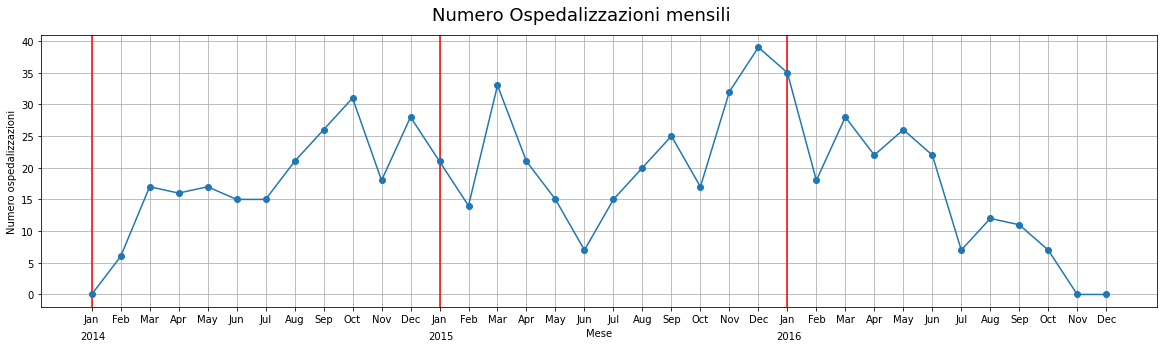

In [ ]:
import calendar

year_month = []
for index, value in table.iterrows():
    year = value.vdate.year
    month = value.vdate.month

    # in maniera tale da avere i gruppi ordinati per anno-mese. Aggiungo 0 ai mesi fino a settembre
    # 01-02-03-04-05-06-07-08-09
    x = 0 if (len(str(month)) == 1) else ''
    concat = int(str(year) + str(x) + str(month))      # 1 misura per mese

    # day = value.vdate.day     # 2 misure per mese
    # day = 0 if (day <= 15) else 1
    # concat = int(str(year) + str(month) + str(day))
    
    # day = value.vdate.day     # 4 misure per mese
    # if (day <= 7):
    #     day = 1         # I° settimana
    # elif (day > 7 and day<=14):
    #     day = 2         # II° settimana
    # elif (day > 14 and day <= 21):
    #     day = 3         # III° settimana
    # else:
    #     day = 4         # IV° settimana
    # concat = int(str(year) + str(month) + str(day))

    year_month.append(concat)

table['year_month'] = year_month

press_mean = table.groupby('year_month')['pressione_mb'].mean().values
osp_sum = table.groupby('year_month')['num_ospedalizzazioni'].sum().values

months = list(range(1, press.size+1))
df = pd.DataFrame({'months':months, 'press_mean':press_mean, 'osp_sum':osp_sum})

df.press_mean

# PLOT RISULTATI

# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,10))
fig, ax1 = plt.subplots(1, 1, figsize=(20,5))
fig.suptitle('Numero Ospedalizzazioni mensili', fontsize=18, y=0.96) # y=0.92 abbassa la posizione del suptitle
ax1.set_xlabel('Mese')
ax1.set_ylabel('Numero ospedalizzazioni')

# ax1.set_xticks(list(range(1, press.size+4, 4)))

#test ---------------------------
ax1.set_xticks(list(range(1, 37)))
months_name = [calendar.month_name[n][:3] for n in range(1, 13)]    # jan-feb-mar-apr-...
ax1.set_xticklabels(months_name+months_name+months_name)
#--------------------------------

# plt.xticks(rotation=90)
for i in range(0, 3):
    ax1.axvline(x=1+12*i, color='red')
    ax1.text(1+12*i-0.4, -7, f'201{4+i}')

ax1.grid()
ax1.plot(months, df.osp_sum, marker='o')

# ax2.set_xticks(list(range(1, press.size+1, 4)))
# ax2.set_yticks(list(range(0, 25, 2)))
# ax2.grid()
# ax2.plot(months, df.osp_sum, marker='o')


# plt.savefig('monthly-osp-sums.png')
# files.download('monthly-osp-sums.png')

In [ ]:
# ======================== CORRELAZIONE DI PEARSON/SPEARMAN SU DESTAGIONALIZZAZIONE DIVERSE ====================================

win_size = 365   # window dimension in days


# creo DataFrame
df = table.drop(columns=['vdate', 'final_dg'])

# Applico metodo destagionalizzaione
for label, content in df.items():
    df[label] = df[label].shift(1)/df[label]
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)


# ========== PEARSON - global synchrony

pearson_r = df.corr()  # method='pearson'
# spearman_r = roll_mean_df.corr(method='spearman')

print(pearson_r)

# pearson_r.to_excel('pearson_r_medie_mobili.xlsx')
# spearman_r.to_excel('spearman_r_medie_mobili.xlsx')

# df.iat[1, 0]  # Access a single value for a row/column pair by integer position


# ========== WINDOWED PEARSON - local synchrony
local_win_size = 365      # window size: 1 month\n 

# win_corr = roll_mean_df['pressione_mb'].rolling(window=local_win_size).corr(roll_mean_df['num_ospedalizzazioni'])
# win_corr.drop(index_to_drop(win_corr), inplace=True)   # drop NaN rows
# win_corr.reset_index(drop=True, inplace=True)   # reset index => starts with index = 0

# plt.figure(figsize=(20, 5))
# plt.title(f'WINDOWED PEARSON su Media Mobile: {local_win_size} days')
# plt.xlabel('Days')
# plt.ylabel('Pearson r')
# plt.xticks(range(0, len(win_corr), 30))
# plt.grid()
# plt.plot(win_corr)


# ======================== Time Lagged Cross Correlation ====================================
# def cross_corr(datax, datay, lag=0, wrap=False):
#     if wrap:
#         shiftedy = datay.shift(lag)
#         shiftedy.iloc[:lag] = datay.iloc[-lag:].values
#         return datax.corr(shiftedy)
#     else: 
#         return datax.corr(datay.shift(lag))

# days_shift = 365     # shift di 90 giorni

# data_x = roll_mean_df['pressione_mb']
# data_y = roll_mean_df['num_ospedalizzazioni']
# x = [cross_corr(data_x, data_y, lag) for lag in range(1, days_shift+1)]

# plt.figure(figsize=(20,5))
# plt.ylabel('Pearson r')
# plt.xlabel('Days shift')
# # plt.xticks(range(0, days_shift, 10), labels=range(0, days_shift, 10))
# plt.grid()
# plt.plot(x)

                      num_ospedalizzazioni  pressione_mb  ...  max_wind  diff_temp
num_ospedalizzazioni              1.000000     -0.130674  ...  0.055305  -0.002073
pressione_mb                     -0.130674      1.000000  ... -0.175840   0.310853
mean_temp                         0.022378     -0.044357  ...  0.180237  -0.083072
min_temp                         -0.011731     -0.238405  ...  0.066852  -0.280432
max_temp                         -0.004776      0.162100  ... -0.021521   0.424354
humidity                          0.026816     -0.197734  ... -0.170783  -0.151335
mean_wind                         0.056307     -0.192867  ...  0.788963  -0.190505
max_wind                          0.055305     -0.175840  ...  1.000000  -0.116308
diff_temp                        -0.002073      0.310853  ... -0.116308   1.000000

[9 rows x 9 columns]


In [ ]:
# ======================== CHECK STATIONARITY TIME SERIES====================================
from statsmodels.tsa.stattools import adfuller

# result = adfuller(table['num_ospedalizzazioni'])
# result = adfuller(table['pressione_mb'], regression = 'ct')
# result = adfuller(np.log(table['mean_temp']))

result = adfuller(rolling_mean(table['mean_temp'], 365))
# # result = adfuller(rolling_mean(table['num_ospedalizzazioni'], 365))
# # result = adfuller(rolling_mean(table['pressione_mb'], 365))

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))
 

# # np.var(table['mean_temp'], ddof=1)

# # data = table['num_ospedalizzazioni'].rolling(window=win_size).mean()    # Calcola media mobile su finestra di win_size

# plt.figure(figsize=(20,5))
# table['pressione_mb'].rolling(window=365).apply(np.mean, raw=True).plot(style='k')

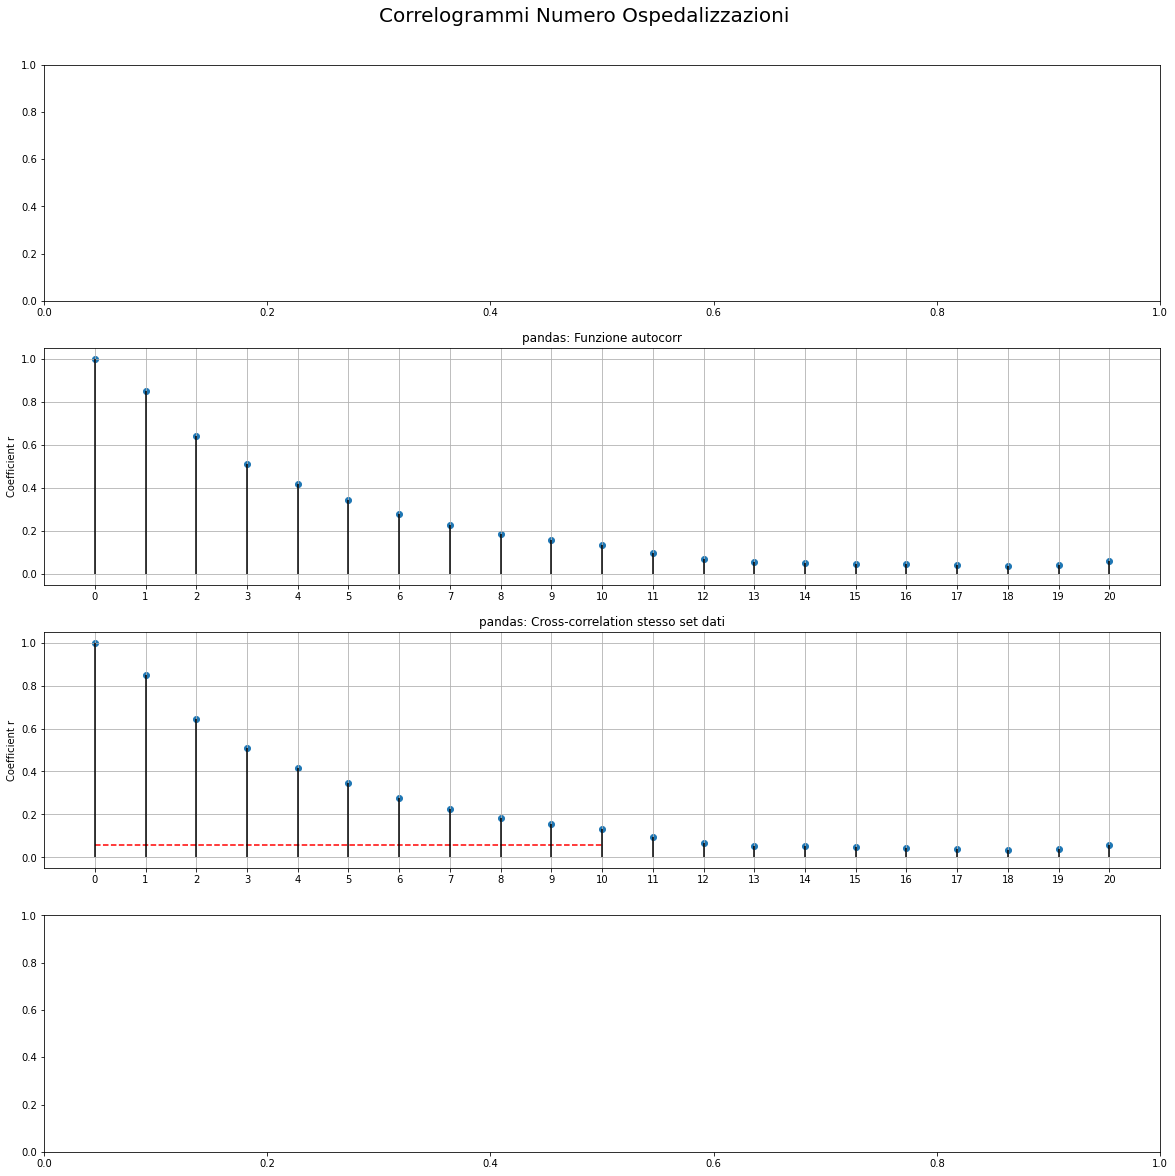

In [ ]:
# ======================== AUTOCORRELOGRAMMI (AUTOCORRELAZIONE) SUB PLOT====================================

# series = rolling_mean(table['pressione_mb'], 365)      # win_size = 365
# series = table['pressione_mb']
# series = table['num_ospedalizzazioni']
# series = table['mean_temp']

# norm = np.linalg.norm(table['pressione_mb'])          # Applicazione norma
# table['pressione_mb'] = table['pressione_mb'] / norm
# series = table['pressione_mb']


series = table['pressione_mb']

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20,20))
fig.suptitle('Correlogrammi Numero Ospedalizzazioni', fontsize=20, y=0.92) # y=0.92 abbassa la posizione del suptitle
max_lags = 20

# ====== Display the autocorrelation plot con libreria:  !! statsmodels !!
# plot_properties = {}
# ax1.set_xticks(list(range(0, max_lags+1)))
# ax1.set_ylabel('Coefficient r')

# tsaplots.plot_acf(series, lags=10, alpha=None, title='statsmodel', vlines_kwargs=plot_properties, ax=ax1)
# ax1.grid()

# ====== Display the autocorrelation plot con libreria:  !! pandas !!

# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,10))
# fig.suptitle('Correlogrammi Pressione (mbar)', fontsize=16)

x_coordinates = range(0, max_lags+1)

# METODO 1
y_coordinates = []
for lag in x_coordinates:
    sigma = series.autocorr(lag=lag)    # calcola singoli indici correlazione, dato un certo lag
    y_coordinates.append(sigma)

ax2.vlines(x_coordinates, 0, y_coordinates)
ax2.set_xticks(list(range(0, max_lags+1)))
ax2.set_ylabel('Coefficient r')
ax2.set_title('pandas: Funzione autocorr')

ax2.scatter(x_coordinates, y_coordinates)
ax2.grid()

# METODO 2
def cross_corr(datax, datay, lag=0, wrap=False):
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))

y_coordinates2 = [cross_corr(series, series, lag) for lag in x_coordinates]

ax3.hlines(y=0.06, xmin=0, xmax=10, color='red', linestyle='dashed')        # 95% confidence band
ax3.vlines(x_coordinates, 0, y_coordinates2)
ax3.set_xticks(list(range(0, max_lags+1)))
ax3.set_ylabel('Coefficient r')
ax3.set_title('pandas: Cross-correlation stesso set dati')
# ax3.set_xlabel('Lags (days)')


ax3.scatter(x_coordinates, y_coordinates2)
ax3.grid()
# plt.show()


# ====== Display the autocorrelation plot con libreria:  !! matplotlib !!
# np_arr = series.to_numpy(dtype = float)

# res = plt.acorr(np_arr)
# x_coord = res[0].tolist()[10:]
# y_coord = res[1].tolist()[10:]


# ax4.set_ylabel('Coefficient r')
# ax4.set_title('matplotlib')
# ax4.set_xlabel('Lags (days)')
# ax4.set_xticks(list(range(0, max_lags+1)))

# ax4.set_xlim([-0.5,11])
# ax4.scatter(x_coord, y_coord)
# ax4.grid()
# plt.show()

# plt.savefig('correlogrammi-pressione.png')
# files.download('correlogrammi-pressione.png')

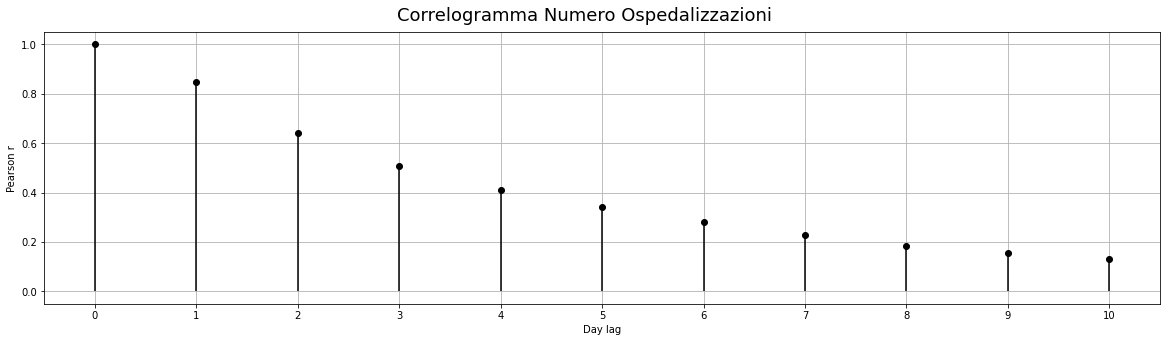

In [ ]:
# ======================== AUTOCORRELOGRAMMI (AUTOCORRELAZIONE)====================================

series = table['pressione_mb']


fig, ax1 = plt.subplots(1, 1, figsize=(20,5))
fig.suptitle('Correlogramma Numero Ospedalizzazioni', fontsize=18, y=0.95) # y=0.92 abbassa la posizione del suptitle
max_lags = 10


x_coordinates = range(0, max_lags+1)
y_coordinates = []
for lag in x_coordinates:
    sigma = series.autocorr(lag=lag)    # calcola singoli indici correlazione, dato un certo lag
    y_coordinates.append(sigma)

ax1.vlines(x_coordinates, 0, y_coordinates)
ax1.set_xticks(list(range(0, max_lags+1)))
ax1.set_ylabel('Pearson r')
ax1.set_xlabel('Day lag')
# ax1.set_title('pandas: Funzione autocorr')

ax1.scatter(x_coordinates, y_coordinates, marker = 'o', color='black')
ax1.grid()
ax1.set_axisbelow(True)     # posiziona grid dietro al plot. Aumenta zorder grid

plt.show()


# plt.savefig('correlogramma-ospedalizzazioni.png')
# files.download('correlogramma-ospedalizzazioni.png')

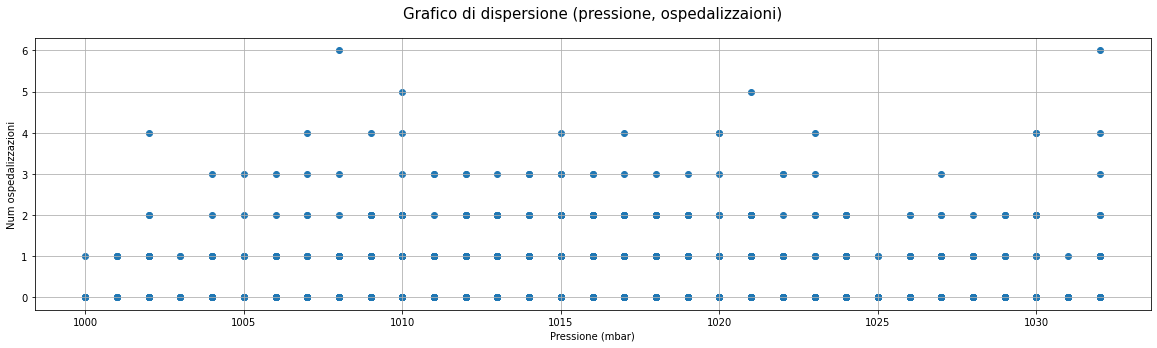

In [ ]:
# ======================== GRAFICO DI DISPERSIONE (PRESSIONE, OSPEDALIZZAZIONI) ====================================
x_df = table['pressione_mb']
y_df = table['num_ospedalizzazioni']

plt.figure(figsize=(20,5))
plt.title('Grafico di dispersione (pressione, ospedalizzaioni)',fontsize=15, y=1.05)
plt.xticks(list(range(980, 1041, 5)))
plt.xlabel('Pressione (mbar)')
plt.ylabel('Num ospedalizzazioni')

x = x_df.to_numpy(dtype = float)
y = y_df.to_numpy(dtype = float)


plt.scatter(x, y)   # add color='black'
plt.grid()


# plt.savefig('Grafico-dispersione-pressione-ospedalizzazioni.png')
# files.download('Grafico-dispersione-pressione-ospedalizzazioni.png')

In [ ]:
# ======================== CORRELAZIONE DI PEARSON (pressione, ospedalizzazioni) ====================================

compact_table = table[['num_ospedalizzazioni', 'pressione_mb']]
# compact_table = compact_table.head(365)   # prendo prime 365 righe => coefficente leggermente + grande

# ======================== PEARSON - global synchrony ==================================== 
# (NON HA SENSO calcolare il coefficente di Pearson per 2 time series)
# coeff_r = compact_table.corr()  # method='pearson'
# coeff_r = table.corr()  # method='pearson'
# print(coeff_r)


# ======================== WINDOWED PEARSON - local synchrony ====================================

def index_to_drop(nan_series):
    index = 0
    index_to_drop = []

    # check from top to bottom
    while math.isnan(nan_series[index]):
        index_to_drop.append(index)
        index += 1
        
    # check from bottom to top
    index = len(nan_series) - 1     # len(nan_series) - 1 => nan_series parte da 0
    while math.isnan(nan_series[index]):
        index_to_drop.append(index)
        index -= 1
    return index_to_drop

# win_size = 30      # window size: 1 month\n

# win_corr = compact_table['pressione_mb'].rolling(window=win_size).corr(compact_table['num_ospedalizzazioni'])    # method='pearson'
# win_corr.drop(index_to_drop(win_corr), inplace=True)   # drop NaN rows
# win_corr.reset_index(drop=True, inplace=True)   # reset index => starts with index = 0

# plt.figure(figsize=(20, 5))
# # df.rolling(window=30,center=True).median().plot(ax=ax[0])
# plt.title(f'WINDOWED PEARSON: {win_size} days')
# plt.xlabel('Days')
# plt.ylabel('Pearson r')
# plt.xticks(range(0, len(win_corr), 30))
# plt.grid()
# plt.plot(win_corr)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

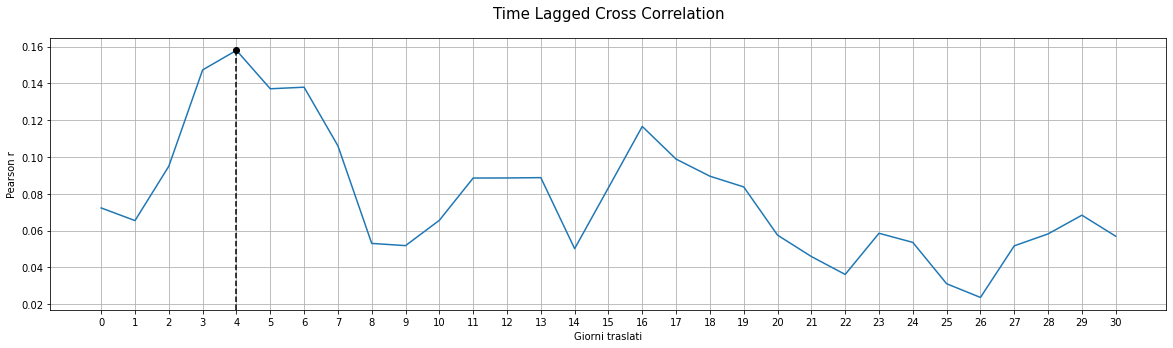

In [ ]:
# ======================== Time Lagged Cross Correlation ====================================
days_shift = 30     # max lagged days

# compute cross-correlation between datax and datay, lagging datax by lag day
def cross_corr(datax, datay, lag=0):
    return datay.corr(datax.shift(lag))

# get time series values from dataframe table
osp_data = table['num_ospedalizzazioni']
press_data = table['pressione_mb']

# compute correlation r for each lag = 0, .., days_shift and storing in list
pearson_arr = [cross_corr(press_data, osp_data, lag) for lag in range(0, days_shift+1)]

# plotting r coefficient
plt.figure(figsize=(20,5))
plt.title('Time Lagged Cross Correlation', fontsize=15, y=1.05)
plt.ylabel('Pearson r')
plt.xlabel('Giorni traslati')
plt.xticks(range(0, days_shift+1, 1), labels=range(0, days_shift+1, 1))

# draw vertical dashed line and dot where max r is found
x_max = np.where(pearson_arr == max(pearson_arr))[0]
plt.axvline(x=x_max, ymax=0.95, color='black', linestyle='dashed')
plt.plot(x_max, pearson_arr[x_max[0]],'-o', color='black', zorder=3) 

# plot graph 
plt.plot(pearson_arr, zorder=2)
plt.grid()


# ======================== WINDOWED Time Lagged Cross Correlation WTLCC====================================
# wlcc_days_shift = 14

# def cross_corr(datax, datay, lag=0, wrap=False):        # lag datax => compute correlation
#     if wrap:
#         shiftedx = datax.shift(lag)
#         shiftedx.iloc[:lag] = datax.iloc[-lag:].values
#         return datay.corr(shiftedy)
#     else: 
#         return datay.corr(datax.shift(lag))

# wtlcc_win_size = 91


# press_data = table.pressione_mb                           #GIOCA SUGLI ANNI DAL QUALE PRELEVI I DATI
# osp_data = table.num_ospedalizzazioni

# arr_person_arr = []

# for n in range(0, press_data.size, wtlcc_win_size):
#     pearson_arr = [cross_corr(press_data[], osp_data, lag) for lag in range(1, days_shift+1)]   # computo 365 correlazioni con lag=0,...,364

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

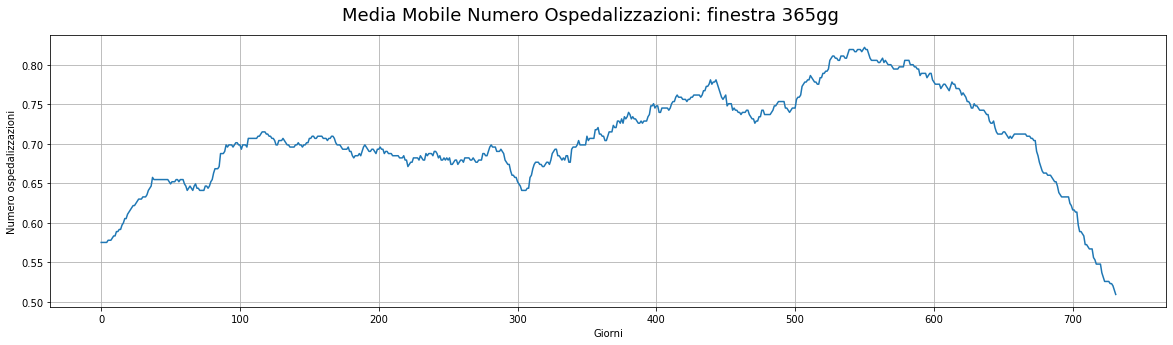

In [ ]:
# ================================================ MOVING AVERAGE ================================================

win_size = 365   # window dimension in days


fig, ax1 = plt.subplots(1, 1, figsize=(20,5))
fig.suptitle('Media Mobile Numero Ospedalizzazioni: finestra 365gg', fontsize=18, y=0.96) # y=0.92 abbassa la posizione del suptitle

# PRESSIONE
pression = rolling_mean(table['num_ospedalizzazioni'], win_size)

# ax1.set_title('Pressione (mbar)')
ax1.set_ylabel('Numero ospedalizzazioni')
ax1.set_xlabel('Giorni')
ax1.grid()
ax1.plot(pression)
# last_xtick = pression.tail(1).index[0]
# ax1.set_xticks(list(ax1.get_xticks()) + [last_xtick])


# OSPEDALIZZAZIONI
# ospedalizzazioni = rolling_mean(table['num_ospedalizzazioni'], win_size)

# ax2.set_title('Ospedalizzazioni')
# ax2.set_ylabel('num ospedalizzazioni')
# ax2.set_xlabel('Giorni')
# ax2.grid()
# ax2.plot(ospedalizzazioni)



# ================================ PLOT SOVRAPPOSTI =============================================
# plt.figure(figsize=(20,5))


# PRESSIONE - Media mobile sovrapposte
# rolling_means = table['pressione_mb'].rolling(window=win_size).mean()
# plt.plot(table.vdate, table['pressione_mb'], label='pressione mb', linewidth=2)
# plt.plot(table.vdate, rolling_means, label='Media mobile', color='red', linewidth=2)
# plt.grid()
# plt.legend()
# plt.show()


# OSPEDALIZZAZIONI - Media mobile sovrapposte
# rolling_means = table['num_ospedalizzazioni'].rolling(window=win_size).mean()
# plt.plot(table.vdate, table['num_ospedalizzazioni'], label='num_osp', linewidth=2)
# plt.plot(table.vdate, rolling_means, label='AMD', color='red', linewidth=2)
# plt.grid()
# plt.legend()
# plt.show()


# plt.savefig('Media-mobile-osp.png')
# files.download('Media-mobile-osp.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 1440x360 with 0 Axes>

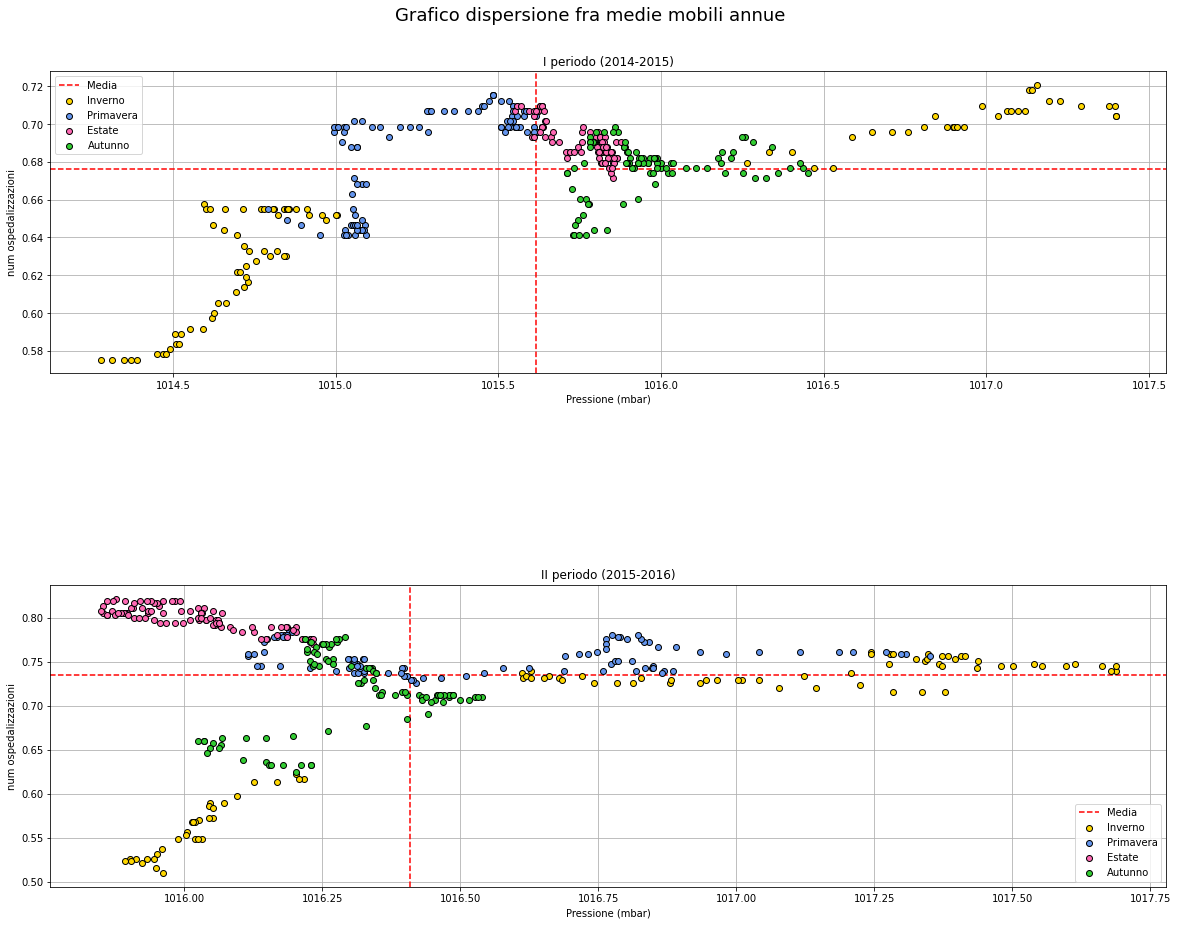

In [ ]:
# ======================== GRAFICO DISPERSIONE FRA MEDIE MOBILI ====================================
plt.figure(figsize=(20,5))

def get_seasons(np_arr):        # sorter arr
    arr = list(np_arr)
    winter = []
    spring = []
    summer = []
    autumn = []

    for i in range(round(len(arr)/365)):
        winter += arr[365*i:59+365*i]
        spring += arr[59+365*i:151+365*i]
        summer += arr[151+365*i:243+365*i]
        autumn += arr[243+365*i:334+365*i]
        winter += arr[334+365*i:365+365*i]

    winter += arr[365*round(len(arr)/365):len(arr)]
    season = []
    season.append(winter)
    season.append(spring)
    season.append(summer)
    season.append(autumn)

    return season


win_size = 365   # window dimension in days

x_roll_mean = rolling_mean(table['pressione_mb'], win_size)
y_roll_mean = rolling_mean(table['num_ospedalizzazioni'], win_size)

x = x_roll_mean.to_numpy(dtype = float)     # pressione_mb
y = y_roll_mean.to_numpy(dtype = float)     # num_ospedalizzazioni

x_seasons = get_seasons(x)
y_seasons = get_seasons(y)


# Plotta risultati
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,13))  OLD
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,15))
fig.suptitle('Grafico dispersione fra medie mobili annue', fontsize=18, y=0.94)

ax1.set_xlabel('Pressione (mbar)')
ax1.set_ylabel('num ospedalizzazioni')
ax2.set_xlabel('Pressione (mbar)')
ax2.set_ylabel('num ospedalizzazioni')

# ax1.grid()
# ax1.scatter(x_seasons[0], y_seasons[0], color='gold', edgecolors='black', label='Inverno')    # winter
# ax1.scatter(x_seasons[1], y_seasons[1], color='cornflowerblue', edgecolors='black', label='Primavera')    # spring
# ax1.scatter(x_seasons[2], y_seasons[2], color='hotpink', edgecolors='black', label='Estate')    # summer
# ax1.scatter(x_seasons[3], y_seasons[3], color='limegreen', edgecolors='black', label='Autunno')    # autumn
# ax1.legend()

press_mean = np.mean(x)
osp_mean = np.mean(y)

# Dati suddivisi esclusivamente in anni e stagioni
ax1.set_title('I periodo (2014-2015)')
ax1.grid()

ax1.axvline(x=x_roll_mean[:365].mean(), color='red', linestyle='dashed', label='Media')
ax1.axhline(y=y_roll_mean[:365].mean(), color='red', linestyle='dashed')
ax1.scatter(x_seasons[0][:len(x_seasons[0])//2], y_seasons[0][:len(x_seasons[0])//2], color='gold', edgecolors='black', label='Inverno', zorder=10)    # winter
ax1.scatter(x_seasons[1][:len(x_seasons[1])//2], y_seasons[1][:len(x_seasons[1])//2], color='cornflowerblue', edgecolors='black', label='Primavera', zorder=10)  # spring
ax1.scatter(x_seasons[2][:len(x_seasons[2])//2], y_seasons[2][:len(x_seasons[2])//2], color='hotpink', edgecolors='black', label='Estate', zorder=10)    # summer
ax1.scatter(x_seasons[3][:len(x_seasons[3])//2], y_seasons[3][:len(x_seasons[3])//2], color='limegreen', edgecolors='black', label='Autunno', zorder=10)    # autumn
ax1.legend()

fig.subplots_adjust(hspace=0.7)

ax2.set_title('II periodo (2015-2016)')
ax2.grid()

ax2.axvline(x=x_roll_mean[365:].mean(), color='red', linestyle='dashed', label='Media')
ax2.axhline(y=y_roll_mean[365:].mean(), color='red', linestyle='dashed')
ax2.scatter(x_seasons[0][len(x_seasons[0])//2:], y_seasons[0][len(y_seasons[0])//2:], color='gold', edgecolors='black', label='Inverno', zorder=10)    # winter
ax2.scatter(x_seasons[1][len(x_seasons[1])//2:], y_seasons[1][len(y_seasons[1])//2:], color='cornflowerblue', edgecolors='black', label='Primavera', zorder=10)  # spring
ax2.scatter(x_seasons[2][len(x_seasons[2])//2:], y_seasons[2][len(y_seasons[2])//2:], color='hotpink', edgecolors='black', label='Estate', zorder=10)    # summer
ax2.scatter(x_seasons[3][len(x_seasons[3])//2:], y_seasons[3][len(y_seasons[3])//2:], color='limegreen', edgecolors='black', label='Autunno', zorder=10)    # autumn
ax2.legend()

# Dati suddivisi esclusivamente in anni
# ax2.grid()
# ax2.scatter(x[:365], y[:365], color='blue', edgecolors='black', label='I anno') 
# ax2.scatter(x[365:len(x)], y[365:len(x)], color='crimson', edgecolors='black', label='II anno')
# ax2.legend()


plt.savefig('Grafico-dispersione-medie-mobili-stagionali.png')
files.download('Grafico-dispersione-medie-mobili-stagionali.png')

In [ ]:
# ======================== CORRELAZIONE DI PEARSON/SPEARMAN SU MEDIA MOBILE ====================================

win_size = 365   # window dimension in days

# creo DataFrame
df = table.drop(columns=['vdate', 'final_dg'])

roll_mean_df = pd.DataFrame()           # df contenente medie mobili colonne
for label, content in df.items():
    roll_mean_df[label] = rolling_mean(df[label], win_size)


pearson_p_values = {}           # Pearson p-value
for label, content in roll_mean_df.items():
    pearson_p_values[label] = round(stats.pearsonr(roll_mean_df[label], roll_mean_df['num_ospedalizzazioni'])[1], 4)

spearman_p_values = {}           # Spearman p-value
for label, content in roll_mean_df.items():
    spearman_p_values[label] = round(stats.pearsonr(roll_mean_df[label], roll_mean_df['num_ospedalizzazioni'])[1], 4)

spearman_p_values

# ========== PEARSON - global synchrony

# pearson_r = roll_mean_df.corr()  # method='pearson'
# spearman_r = roll_mean_df.corr(method='spearman')
# print(pearson_r)
# pearson_r.to_excel('pearson_r_medie_mobili.xlsx')
# spearman_r.to_excel('spearman_r_medie_mobili.xlsx')

# df.iat[1, 0]  # Access a single value for a row/column pair by integer position


# ========== WINDOWED PEARSON - local synchrony
# local_win_size = 365      # window size: 1 month\n 

# win_corr = roll_mean_df['pressione_mb'].rolling(window=local_win_size).corr(roll_mean_df['num_ospedalizzazioni'])
# win_corr.drop(index_to_drop(win_corr), inplace=True)   # drop NaN rows
# win_corr.reset_index(drop=True, inplace=True)   # reset index => starts with index = 0

# plt.figure(figsize=(20, 5))
# plt.title(f'Windowed Pearson su media mobile annua', fontsize=15, y=1.04)
# plt.xlabel('Giorni')
# plt.ylabel('Pearson r')
# plt.xticks(range(0, len(win_corr), 30))
# plt.grid()
# plt.plot(win_corr)

# plt.savefig('Windowed-pearson.png')
# files.download('Windowed-pearson.png')

# ======================== Time Lagged Cross Correlation ====================================
# def cross_corr(datax, datay, lag=0, wrap=False):
#     if wrap:
#         shiftedy = datay.shift(lag)
#         shiftedy.iloc[:lag] = datay.iloc[-lag:].values
#         return datax.corr(shiftedy)
#     else: 
#         return datax.corr(datay.shift(lag))

# days_shift = 365     # shift di 90 giorni

# data_x = roll_mean_df['pressione_mb']
# data_y = roll_mean_df['num_ospedalizzazioni']
# x = [cross_corr(data_x, data_y, lag) for lag in range(1, days_shift+1)]

# plt.figure(figsize=(20,5))
# plt.ylabel('Pearson r')
# plt.xlabel('Days shift')
# # plt.xticks(range(0, days_shift, 10), labels=range(0, days_shift, 10))
# plt.grid()
# plt.plot(x)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

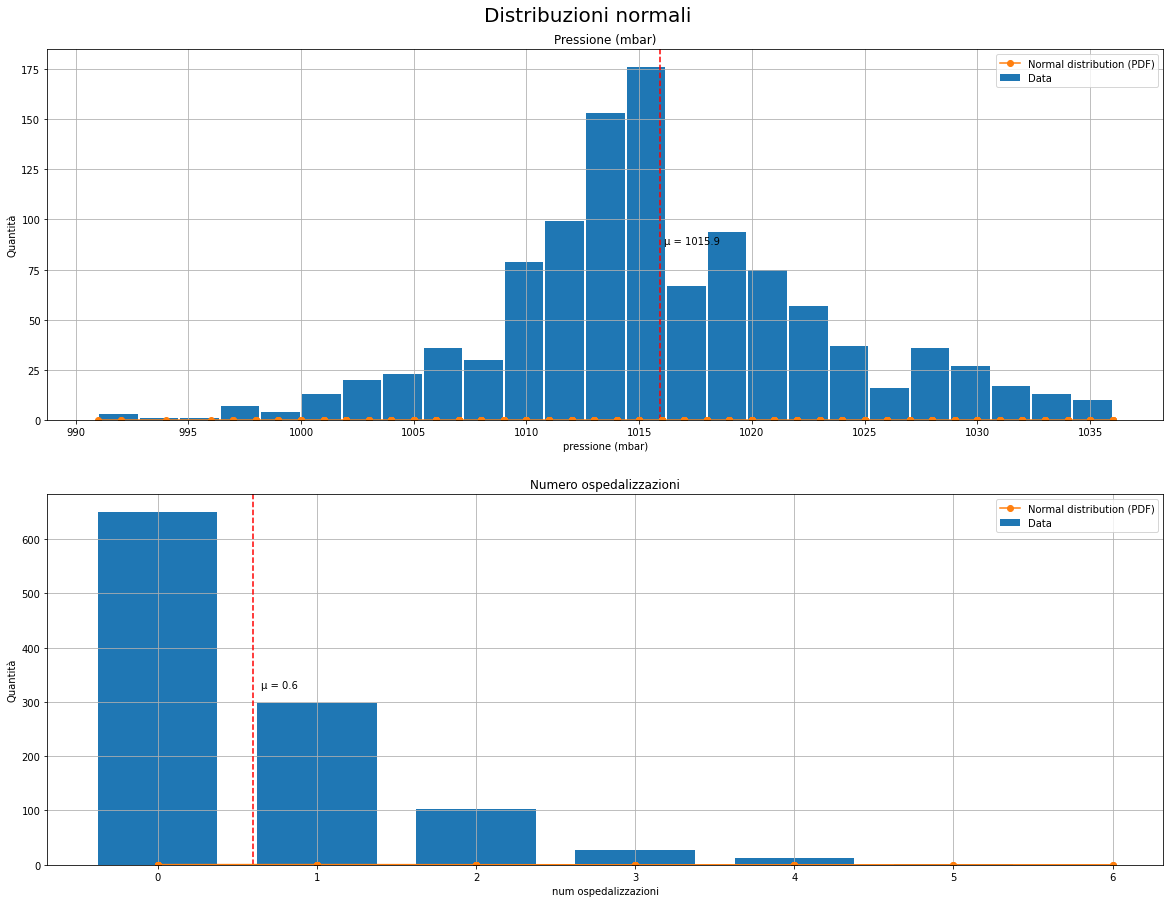

In [ ]:
 # ======================== STUDIO DISTRIBUZIONE ====================================
 import scipy.stats as stats
 import math

def normpdf(x, mean, sd):
    var = float(sd)**2
    denom = (2*math.pi*var)**.5
    num = math.exp(-(float(x)-float(mean))**2/(2*var))
    return num/denom

pressions = table['pressione_mb'].to_numpy()
num_ospedalizzazioni = table['num_ospedalizzazioni'].to_numpy()


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,15))
fig.suptitle('Distribuzioni normali', fontsize=20, y=0.92)

# PRESSIONE_MB - Normal distribution
weights = np.ones_like(pressions)/len(pressions)

ax1.set_title('Pressione (mbar)')
ax1.set_ylabel('Quantità')
ax1.set_xlabel('pressione (mbar)')
ax1.set_xticks(list(range(980, 1040, 5)))
ax1.set_xticklabels(list(range(980, 1040, 5)))
ax1.grid()
h1 = ax1.hist(pressions, bins=25, rwidth=0.95, weights=weights, label='Data')  # density=False would make counts

press_mean = np.mean(pressions)
fit = stats.norm.pdf(np.sort(pressions), np.mean(pressions), np.std(pressions))  # normal distribution function

ax1.axvline(x=press_mean, color='red', linestyle='dashed')
ax1.text(press_mean+0.2, max(h1[0])/2, f'μ = {round(press_mean,2)}')
ax1.plot(np.sort(pressions), fit, '-o', label='Normal distribution (PDF)')
ax1.legend()


# NUM_OSPEDALIZZAZIONI - Poisson distribution
# Poisson distribution is just another approximation of Binomial distribution,
# but better than normal distribution when n is large and p is small. More precisely when average is approximately same as variance
# weights = np.ones_like(num_ospedalizzazioni)/len(num_ospedalizzazioni)

ax2.set_title('Numero ospedalizzazioni')
ax2.set_ylabel('Quantità')
ax2.set_xlabel('num ospedalizzazioni')
ax2.grid()

bins = np.arange(7) - 0.5   # permette di avere i bin centrati con gli xticks
h2 = ax2.hist(num_ospedalizzazioni, bins=bins, rwidth=0.75, weights=weights, label='Data')  # density=False would make counts
osp_mean = np.mean(num_ospedalizzazioni)
fit = stats.norm.pdf(np.sort(num_ospedalizzazioni), osp_mean, np.std(num_ospedalizzazioni))  # Probability Density Function

ax2.axvline(x=osp_mean, color='red', linestyle='dashed')
# print(max(ax2.get_xticks()))
ax2.text(osp_mean+0.05, max(h2[0])/2, f'μ = {round(osp_mean,2)}')
# # ax2.xticks([0,osp_mean,1,2,3,4,5,6], labels=[0,f'μ = {round(osp_mean,2)}',1,2,3,4,5,6])

ax2.plot(np.sort(num_ospedalizzazioni), fit, '-o', label='Normal distribution (PDF)')
ax2.legend()


# plt.savefig('Distribuzioni normali.png')
# files.download('Distribuzioni normali.png')

In [ ]:
# ===============================================================================================================================
# ================================================ VALORI SEMI_ORARI ============================================================
# ===============================================================================================================================
import datetime

data = pd.read_csv('POLO_SCIENTIFICO_(LAMMA).txt', sep="\t", header=None)
data.columns = ["date", "mean_temp", "rel_humidity", "pression"]
# data.isnull().values.any()    # => False

# Cancello I° riga che contiene i titoli
data.drop(data.index[[0]], inplace=True)        
data.reset_index(drop=True, inplace=True)

# Conversione dati
data.date = pd.to_datetime(data['date'])
data.pression = pd.to_numeric(data['pression'], errors='coerce')        # string -> int


# Pulizia dati file .txt
data['pression'].replace(-999, np.NaN, inplace=True)    # Sul file .txt i valori ignoti contengono -999 => sostituisco np.NaN
data.interpolate(method='linear', limit_direction='forward', axis=0, inplace=True)
data = data.round(1)        # arrotondo a prima cifra decimale => su file sono arrotondati a decimale 0.5


# Calcola variazioni di pressione
date = []       # data
current_day = datetime.date(2014,1,1)     # data iniziale
var_press = []  # variazione pressione giornaliera
sum_diff=0
for index, value in data[1:].iterrows():        # non considero index == 0
    sum_diff += abs(value.pression - data.iloc[index-1]['pression'])

    if (index % 48 == 0 or index == data['pression'].size-1):  # calcolo differenze fino a 00 del giorno dopo current_day == datetime.date(2016, 1, 1)
        # print(current_day.strftime("%Y-%m-%d"))
        date.append(current_day)       # prendo solo anno - mese - giorno
        var_press.append(sum_diff)
        
        current_day += datetime.timedelta(days=1)
        sum_diff = 0


semi_orari = pd.DataFrame({'date': date, 'var_press':var_press, 'num_ospedalizzazioni':table['num_ospedalizzazioni']}) # da 2014-01-01 a 2016-12-31


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

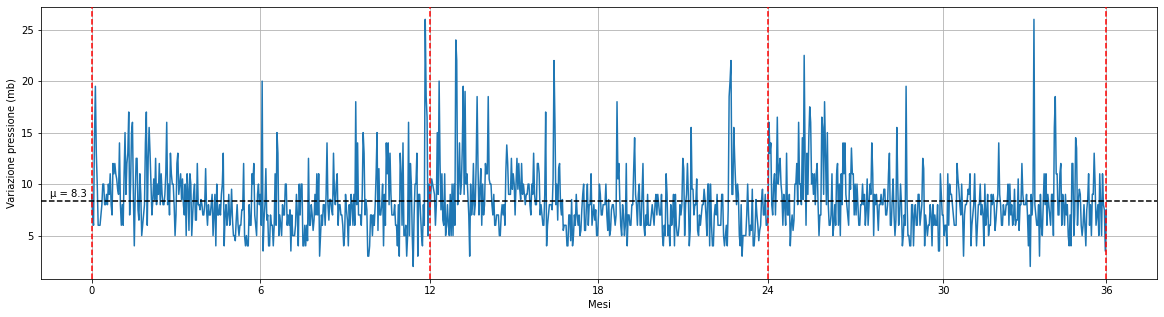

In [ ]:
# =========================================== PLOT SERIE STORICHE

# NORMALE
x_press = semi_orari['var_press']
y_osp = semi_orari['num_ospedalizzazioni']   

# y_osp=y_osp+8
plt.figure(figsize=(20,5))
plt.axhline(y=x_press.mean(), color='black', linestyle='dashed', zorder=5)
plt.text(-45, x_press.mean()+0.4, f'μ = {round(x_press.mean(),1)}')

mesi = [0, 182, 365, 547, 730, 919, 1095]
plt.xticks(mesi, labels=['0', '6', '12', '18', '24', '30', '36'])
for i in range(4):
    plt.axvline(x=365*i, color='red', linestyle='dashed', zorder=20)

plt.ylabel('Variazione pressione (mb)')
plt.xlabel('Mesi')
plt.plot(x_press)
plt.grid()
# plt.show()


# MEDIA MOBILE (mm)
# x_press_mm = rolling_mean(x_press, 4)
# y_osp_mm = rolling_mean(y_osp, 4)

# y_osp_mm = y_osp_mm + 8
# plt.figure(figsize=(20,5))
# plt.axhline(y=x_press_mm.mean(), color='black', linestyle='dashed', zorder=5)
# plt.plot(x_press_mm)
# plt.plot(y_osp_mm, color='red')
# plt.grid()
# plt.show()


# SCATTER PLOT
# plt.figure(figsize=(20,5))
# plt.ylabel('Variazione pressione (mb)')
# plt.xlabel('Ospedalizzazioni')
# plt.scatter(y_osp_mm, x_press_mm)
# plt.grid()

plt.savefig('var-press-time-series.png')
files.download('var-press-time-series.png')

In [ ]:
# =========================================== CORRELAZIONE
# semi_orari.corr()
# semi_orari.corr(method='spearman')

# days_before = 4
# var_press_mean = semi_orari['var_press'][-365:].rolling(days_before).mean()
# num_osp_sum = semi_orari['num_ospedalizzazioni'][-365:]
# # num_osp_sum = semi_orari['num_ospedalizzazioni'].rolling(days_before).sum()
# df = pd.DataFrame({'var_press_mean':var_press_mean, 'num_osp_sum':num_osp_sum})

# df.corr(method='spearman')

# TLCC
days_shift = 7

def cross_corr(datax, datay, lag=0, wrap=False):        # lag datax => compute correlation
    if wrap:
        shiftedx = datax.shift(lag)
        shiftedx.iloc[:lag] = datax.iloc[-lag:].values
        return datay.corr(shiftedy)
    else: 
        return datay.corr(datax.shift(lag))
    
pearson_arr = [cross_corr(semi_orari['var_press'][-365:], semi_orari['num_ospedalizzazioni'][-365:], lag) for lag in range(0, days_shift)] 
pearson_arr

plt.figure(figsize=(20,5))
plt.title('Time Lagged Cross Correlation', fontsize=15, y=1.05)
plt.ylabel('Pearson r')
plt.xlabel('Giorni traslati')
plt.xticks(range(0, days_shift, 1), labels=range(0, days_shift, 1))

x_max = np.where(pearson_arr == max(pearson_arr))[0]
x_min = np.where(pearson_arr == max(pearson_arr))[0]
plt.axvline(x=x_max if(abs(x_max) > abs(x_min)) else x_min, ymax=0.95, color='black', linestyle='dashed')
# plt.text(x_max-0.3, 0.009, f'{x_max[0]}gg', zorder=10)


plt.grid()
y = plt.plot(pearson_arr, zorder=2)

plt.plot(x_max, pearson_arr[x_max[0]],'-o', color='black', zorder=3) 

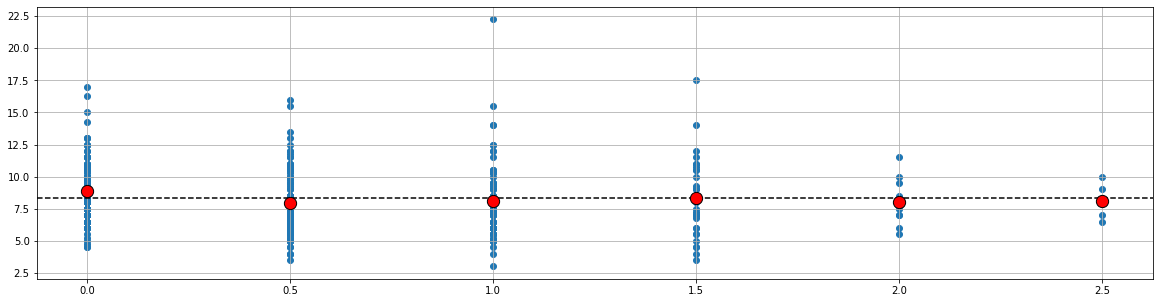

In [ ]:
# ===================================================== SCATTER PLOT MEDIE VARIAZIONI + MEDIE OSPEDALIZZAZIONI
days_before = 2

var_press_mean = semi_orari['var_press'][:365].rolling(days_before).mean()
num_osp_mean = semi_orari['num_ospedalizzazioni'][:365].rolling(days_before).mean().round(1)
df = pd.DataFrame({'var_press_mean':var_press_mean, 'num_osp_mean':num_osp_mean})


plt.figure(figsize=(20,5))
# plt.hlines(y=var_press_mean.mean(), xmin=0, xmax=max(num_osp_mean[days_before-1:]), color='black', linestyle='dashed') 
plt.axhline(y=var_press_mean.mean(), color='black', linestyle='dashed')    


# calcola medie per ogni ospedalizzazione
mean_to_add = []
unique_num_osp = list(num_osp_mean[days_before-1:].unique())
for num_osp in unique_num_osp:
    var_press_values = df[df['num_osp_mean'] == num_osp]['var_press_mean']
    mean_to_add.append(var_press_values.mean())

# plot media osp, punti rossi
mean_to_add = [round(mean, 2) for mean in mean_to_add]
plt.scatter(unique_num_osp, mean_to_add, color='red', edgecolor='black', zorder=10, s=150)

# plot grafico
plt.scatter(num_osp_mean, var_press_mean)
plt.grid()

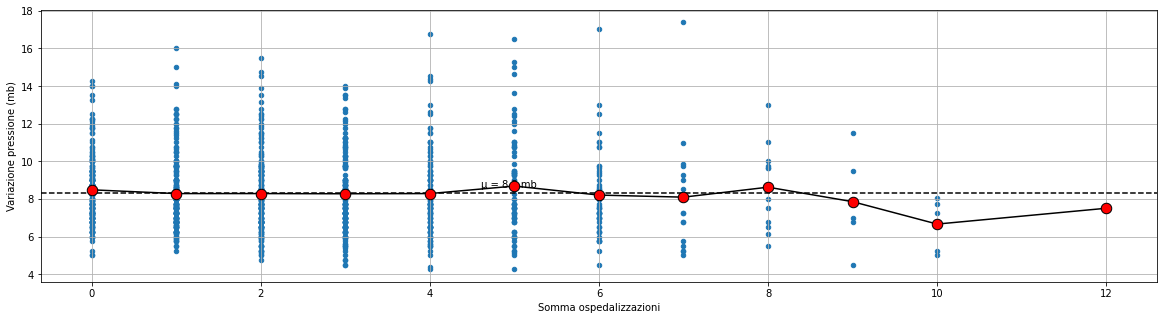

In [ ]:
# ===================================================== SCATTER PLOT MEDIE su var_press + SOMME OSPEDALIZZAZIONI
days_lookahead = 4

zero_lookahead = False
var_press = semi_orari['var_press'] if (zero_lookahead) else semi_orari['var_press'].rolling(days_lookahead).mean()
num_osp = semi_orari['num_ospedalizzazioni'] if (zero_lookahead) else semi_orari['num_ospedalizzazioni'].rolling(days_lookahead).sum()
df = pd.DataFrame({'var_press':var_press, 'num_osp':num_osp})

plt.figure(figsize=(20,5))
var_press_mean = var_press.mean()
plt.axhline(y=var_press_mean, color='black', linestyle='dashed')
plt.text(4.6, var_press_mean+0.3, f'μ = {round(var_press_mean,1)} mb')

# calcola medie per ogni ospedalizzazione
mean_to_add = []
unique_num_osp = sorted(list(num_osp.unique()))
unique_num_osp = [n for n in unique_num_osp if str(n) != 'nan']      # remove nan values

for x in unique_num_osp:
    var_press_values = df[df['num_osp'] == x]['var_press']
    mean_to_add.append(var_press_values.mean())


# plot media osp, punti rossi
mean_to_add = [round(mean, 2) for mean in mean_to_add]
plt.scatter(unique_num_osp, mean_to_add, color='red', edgecolor='black', zorder=10, s=110)
plt.plot(unique_num_osp, mean_to_add, color='black')

# plot grafico
# plt.scatter(num_osp, var_press, edgecolor='white', s=40)
plt.scatter(num_osp, var_press, s=20)

plt.ylabel('Variazione pressione (mb)')
plt.xlabel('Somma ospedalizzazioni')
plt.grid()


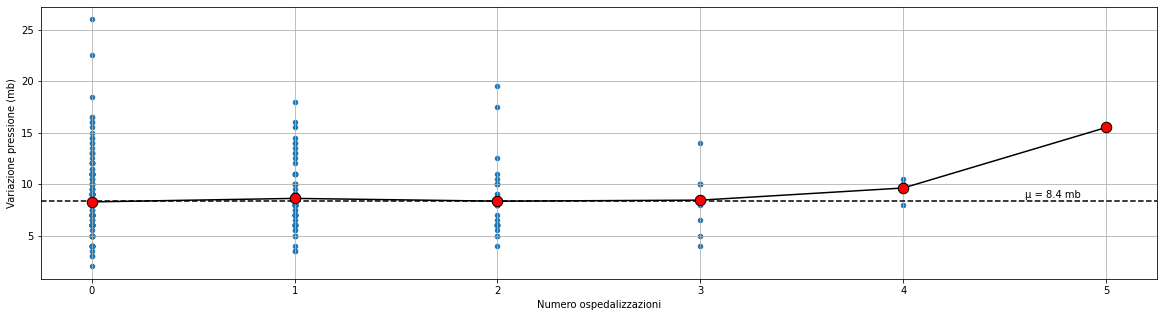

In [ ]:
# ===================================================== SCATTER PLOT -  MEDIE su var_press
days_lookahead = 1

zero_lookahead = False
var_press = semi_orari['var_press'] if (zero_lookahead) else semi_orari['var_press'][-365:].rolling(days_lookahead).mean()
num_osp = semi_orari['num_ospedalizzazioni'][-365:]
df = pd.DataFrame({'var_press':var_press, 'num_osp':num_osp})


plt.figure(figsize=(20,5))
var_press_mean = var_press.mean()
plt.axhline(y=var_press_mean, color='black', linestyle='dashed')
# plt.text(-0.27, var_press_mean+0.25, f'μ = {round(var_press_mean,1)}')
plt.text(4.6, var_press_mean+0.3, f'μ = {round(var_press_mean,1)} mb')

# calcola medie per ogni ospedalizzazione
mean_to_add = []
# unique_num_osp = list(num_osp.unique()).sort()
unique_num_osp = list(range(7))         # 1,2,3,4,5,6

for x in unique_num_osp:
    var_press_values = df[df['num_osp'] == x]['var_press']
    mean_to_add.append(var_press_values.mean())


# plot media osp, punti rossi
mean_to_add = [round(mean, 2) for mean in mean_to_add]
plt.scatter(unique_num_osp, mean_to_add, color='red', edgecolor='black', zorder=10, s=110)
plt.plot(unique_num_osp, mean_to_add, color='black')

# plot grafico
# plt.scatter(num_osp, var_press, edgecolor='white', s=40)
plt.scatter(num_osp, var_press, s=20)

plt.ylabel('Variazione pressione (mb)')
plt.xlabel('Numero ospedalizzazioni')
plt.grid()


# plt.savefig('var-press-scatter-lag4.png')
# files.download('var-press-scatter-lag4.png')

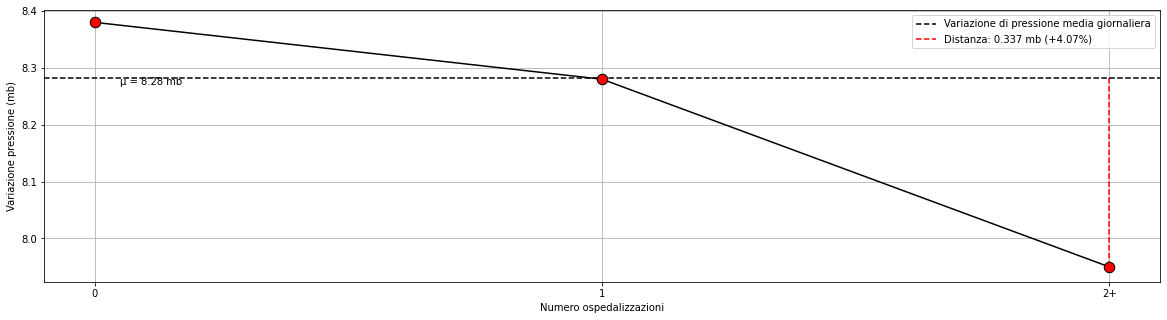

In [ ]:
# ===================================================== SCATTER PLOT -  MEDIE su var_press    0-1-2+
days_lookahead = 7

var_press = semi_orari['var_press'][365:730].rolling(days_lookahead).mean()
num_osp = semi_orari['num_ospedalizzazioni'][365:730]
df = pd.DataFrame({'var_press':var_press, 'num_osp':num_osp})

index = list(df[df['num_osp'] >= 2].index.values)
df.loc[index, 'num_osp'] = 2


var_press_mean = var_press.mean()

plt.figure(figsize=(20,5))
plt.axhline(y=var_press_mean, color='black', linestyle='dashed', label='Variazione di pressione media giornaliera')
plt.text(0.05, var_press_mean*0.9985, f'μ = {round(var_press_mean,2)} mb')

# calcola medie per ogni ospedalizzazione
mean_to_add = []
unique_num_osp = list(range(3))

for x in unique_num_osp:
    var_press_values = df[df['num_osp'] == x]['var_press']
    mean_to_add.append(var_press_values.mean())

dis = round(abs(mean_to_add[-1] - var_press_mean), 3)
percent_dis = round((dis*100)/var_press_mean, 2)
plt.vlines(x=2, ymin=var_press_mean, ymax=mean_to_add[-1], color='red', linestyle='dashed', label=f'Distanza: {dis} mb (+{percent_dis}%)')

# plot media osp, punti rossi
mean_to_add = [round(mean, 2) for mean in mean_to_add]
plt.scatter(unique_num_osp, mean_to_add, color='red', edgecolor='black', zorder=10, s=110)
plt.plot(unique_num_osp, mean_to_add, color='black')

# plot grafico
plt.xticks([0,1,2], labels=['0','1','2+'])

plt.ylabel('Variazione pressione (mb)')
plt.xlabel('Numero ospedalizzazioni')
plt.legend()
plt.grid()


# plt.savefig('var-press-012+-lag1.png')
# files.download('var-press-012+-lag1.png')

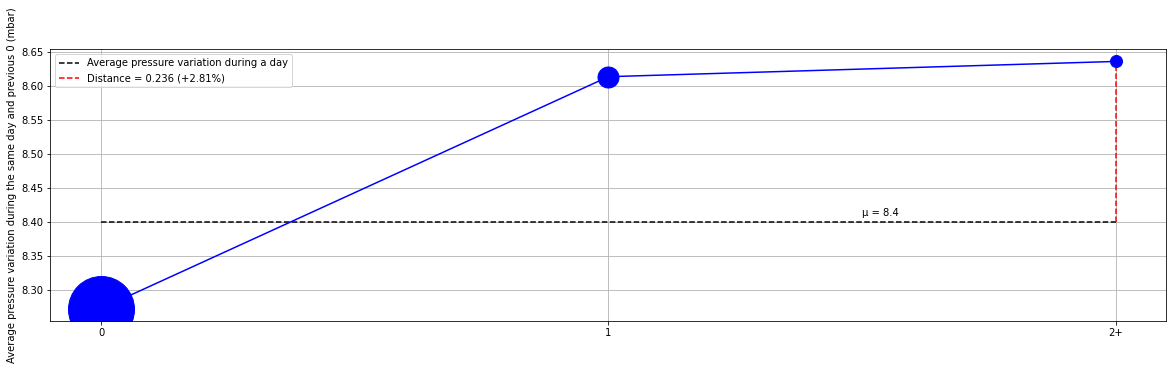

In [ ]:
# ======================================================================================================================================
# ======================================================= METODO Fanti Pietro ================================================================
# ======================================================================================================================================
class Series:
    def __init__(self, values: list, label: str = None):
        self.values = list(values)
        self.label = self.values.pop(0) if label is None else label

    def __getitem__(self, item):
        if isinstance(item, slice):
            return Series(self.values[item.start:item.stop:item.step], self.label)
        else:
            return self.values[item]

    def __len__(self):
        return len(self.values)


    def mobile_mean(self, window: int, ws=None):
        if ws is None:
            new_label = "Mobile mean of: {}".format(self.label)
            ws = [1 / window] * window
        else:
            new_label = "Mobile mean (weights={}) of: {}".format(ws, self.label)
        assert len(ws) == window, \
            "in Series.mobile_mean(window, ws), len(ws) is {} and window is {}. They must be equal".format(
                str(len(ws), ), str(window))
        assert abs(sum(ws) - 1) < 0.01, \
            "in Series.mobile_mean(window,ws), sum(ws) is {}. it must be 1".format(sum(ws))
        mobile_mean: list = []
        for i in range(len(self.values) - window + 1):
            mean = j = 0
            for v in self.values[i: i + window]:
                mean += v * ws[j]
                j += 1
            mobile_mean.append(mean)
        return Series(mobile_mean, new_label)

# ======================================================================================================================================
# ======================================================================================================================================
# ====================================================================================================================================== 
class Correlation:
    def __init__(self, x: Series, y: Series):
        self.x = x
        self.y = y

    def __getitem__(self, item):
        if isinstance(item, slice):
            return Correlation(self.x[item.start:item.stop:item.step], self.y[item.start:item.stop:item.step])
        else:
            return self.x[item], self.y[item]

    def draw_means(self, _max: int = None, xlabel: str = None, ylabel: str = None, hlabel: str = None):
        plt.figure(figsize=(20,5))
        if _max is None:
            _max = int(max(self.x))
            max_label = str(_max)
        else:
            max_label = str(_max) + "+"
        sum_length = [[0, 0]]
        for i in range(_max):
            sum_length.append([0, 0])
        for i in range(len(self.x)):
            _x = int(self.x[i])
            _x = _max if _x >= _max else _x
            _y = self.y[i]
            sum_length[_x][0] += _y
            sum_length[_x][1] += 1
        means = []
        for s, l in sum_length:
            means.append(s / l)
        for i in range(len(means)):
            plt.plot(i, means[i], 'bo', markersize=int(sum_length[i][1] / len(self.x) * 100))
        plt.plot(means, 'b')
        xlabel = self.x.label if xlabel is None else xlabel
        ylabel = self.y.label if ylabel is None else ylabel
        hlabel = "Mean of {}".format(ylabel) if hlabel is None else hlabel
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        xticks = []
        for i in range(_max):
            xticks.append(str(i))
        xticks.append(max_label)
        plt.xticks(range(_max + 1), xticks)
        _mean = round(np.mean(self.y.values), 1)
        # _mean = 8.3
        ymax = means[_max]
        plt.hlines(_mean, 0, _max, linestyles="dashed",
                   label=hlabel)
        plt.annotate(f'μ = {round(_mean, 1)}', xy=(_max - 0.5, _mean * 1.0010), xycoords='data')
        plt.vlines(_max, _mean, ymax, linestyles="dashed", colors="r",
                   label="Distance = {} (+{}%)".format(str(round(ymax - _mean, 3)),
                                                       str(round((ymax - _mean) / _mean * 100, 2))))
        plt.legend()
        plt.grid()
        plt.show()

# ======================================================================================================================================
# ======================================================================================================================================
# ====================================================================================================================================== 



def plot_graph(series, hosp, w):
    series = series.mobile_mean(w)
    for k in range(w - 1):
        hosp.values.pop(0)
    corr = Correlation(hosp, series)
    corr.draw_means(_max=2,
                    ylabel="Average pressure variation during the same day and previous {} (mbar)".format(w - 1),
                    hlabel="Average pressure variation during a day")


hospitalizations = semi_orari['num_ospedalizzazioni'][-365:].tolist()
daily_variations = semi_orari['var_press'][-365:].tolist()

hospitalizations = Series(hospitalizations, "")
var_series = Series(daily_variations, "")

# var_series_test = var_series[:365]
# hospitalizations_test = hospitalizations[:365]
# plot_graph(var_series_test, hospitalizations_test, 4)

plot_graph(var_series, hospitalizations, 1)

In [ ]:
# ===============================================================================================================================
# ================================================= TRANSFER ENTROPY ============================================================
# ===============================================================================================================================
def adjust_file_delimiters(fileIN, fileOUT, sep=' '):
    fin = open(fileIN, 'r')
    fout = open(fileOUT, 'w')
    for line in fin:
    	fout.write(sep.join(line.split())+'\n')
    fin.close()
    fout.close()


# adjust_file_delimiters('TE_k3.txt', 'TE_k3_fin.txt')
te_df = pd.read_csv('TE_k3_fin.txt', sep=' ', error_bad_lines=False)
te_df[1:]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

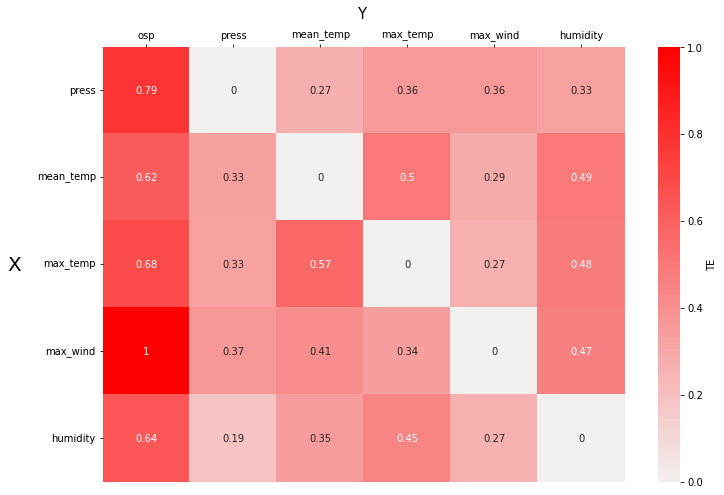

In [ ]:
# NORMALIZZO HEATMAP
norm_te_df = te_df/te_df.values.max()       # normalizzo dividendo per il valore + grande osservato
norm_te_df = norm_te_df[1:]             # non considero prima riga == osp, non mi interessa di TE_{osp->var_meteo}
# data = []
# labels =  []

# data.append([0,0, 0, 0, 0, 0, 0])
# labels.append(['---','---', '---', '---', '---', '---', '---'])
# for i in range(1,7):
#     value = norm_te_df.values[i].round(4).tolist()

#     data.append(value)
#     labels.append(value)

# data = np.asarray(data)
# labels = np.asarray(labels)

# PLOT HEATMAP
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

ax.set_xlabel('X')
ax.set_xlabel('Y')
sns.heatmap(norm_te_df, annot=True, square=True, cmap=sns.light_palette('red', as_cmap=True), cbar_kws={'label': f'TE'}, ax=ax)# , annot=labels, fmt = '' se considero prima riga
plt.suptitle('Y', x=0.4415, y=0.95, fontsize=15)
plt.text(-1.1, 2.57, 'X', fontsize=20)
ax.set_yticklabels(norm_te_df.index.tolist(), va='center', rotation = 0, position=(0,0.28))
ax.tick_params(labelbottom = False, bottom=False, top = True, labeltop=True)
# plt.show()


plt.savefig('Heatmap-TE-k3.png')
files.download('Heatmap-TE-k3.png')